In [17]:
import os
import re
import sys
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer

In [18]:
# def get_x_y_z(filename):
#     a = re.findall("-?[0-9]+[.]?[0-9]*", filename.split("/")[-1])[:-1]
#     return [float(i) for i in a]

get_x = lambda filename: get_x_y_z(filename)[0]
get_z = lambda filename: get_x_y_z(filename)[2]

In [19]:
lt_dir = os.path.expandvars("../files/S1/")
lt_filenames = glob.glob(os.path.join(lt_dir, "*.h5"))
lt_filenames = sorted(lt_filenames)

detector_db = "new"
datapmt = load_db.DataPMT(detector_db, 0)
xpmt, ypmt = datapmt["X"].values, datapmt["Y"].values
sensorids  = datapmt["SensorID"].values

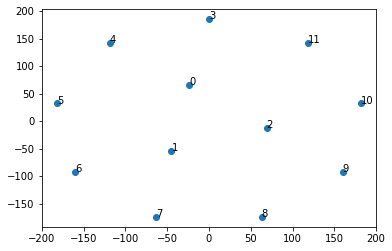

In [20]:
plt.scatter(xpmt, ypmt)
for x, y, sid  in zip(xpmt, ypmt, sensorids):
    plt.annotate(sid, (x, y))

In [21]:
filename = lt_filenames[1]

print(filename)
x = -20
y = -20
z = 50
print("x=", x, "y=", y, "z=", z)

../files/S1/NEW_S1_LT_12.next.h5
x= -20 y= -20 z= 50


In [22]:
configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
num_events = int(configuration.loc["num_events"][0])
nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

sns_response  = pd.read_hdf(filename, "MC/sns_response")
pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]

In [23]:
# protection time bins
pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()

In [24]:
mean = pmt_response.groupby("sensor_id")["charge"].mean()
std  = pmt_response.groupby("sensor_id")["charge"].std()

LT  = mean/nphotons 
err = std/mean*100

In [25]:
# to df
LT = LT.to_frame().reset_index()
LT["x"] = x; LT["y"] = y; LT["z"] = z;
err = err.to_frame().reset_index()
err["x"] = x; err["y"] = y; err["z"] = z;

LT  = pd.pivot_table(LT , values="charge", columns="sensor_id", index=["x", "y", "z"])
err = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
LT .columns = LT .columns.rename("")
err.columns = err.columns.rename("")

In [26]:
LT  = pd.DataFrame()
ERR = pd.DataFrame()

for i, filename in enumerate(lt_filenames, 1):
    sys.stdout.write(f"Processing file {i}/{len(lt_filenames)} \r")
    sys.stdout.flush()
    
    # x, y, z = get_x_y_z(filename)
    x = -20+i
    y = -20+i
    z = 50+i
    
    configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
    num_events = int(configuration.loc["num_events"][0])
    nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

    sns_response  = pd.read_hdf(filename, "MC/sns_response")
    pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]
    
    # protection time bins
    pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()
    
    mean = pmt_response.groupby("sensor_id")["charge"].mean()
    std  = pmt_response.groupby("sensor_id")["charge"].std()

    lt  = mean/nphotons 
    err = std/mean*100
    
    # to df
    lt = lt.to_frame().reset_index()
    lt["x"] = x; lt["y"] = y; lt["z"] = z;
    err = err.to_frame().reset_index()
    err["x"] = x; err["y"] = y; err["z"] = z;

    lt  = pd.pivot_table(lt , values="charge", columns="sensor_id", index=["x", "y", "z"])
    err = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
    
    LT  = pd.concat([LT , lt])
    ERR = pd.concat([ERR, err])

In [27]:
display(LT.head(10))

,,sensor_id,0,1,2,3,4,5,6,7,8,9,10,11
x,y,z,,,,,,,,,,,,
-19,-19,51,0.001187,0.001203,0.001212,0.000842,0.000844,0.000845,0.000850,0.000874,0.000892,0.000873,0.000862,0.000848
-18,-18,52,0.001194,0.001192,0.001232,0.000869,0.000856,0.000843,0.000851,0.000886,0.000884,0.000900,0.000899,0.000896
-17,-17,53,0.001218,0.001203,0.001207,0.000867,0.000869,0.000875,0.000866,0.000864,0.000864,0.000855,0.000861,0.000865
-16,-16,54,0.001205,0.001235,0.001199,0.000852,0.000866,0.000880,0.000906,0.000887,0.000862,0.000857,0.000858,0.000854
-15,-15,55,0.001231,0.001276,0.001242,0.000873,0.000880,0.000899,0.000917,0.000906,0.000899,0.000895,0.000896,0.000887
-14,-14,56,0.001215,0.001190,0.001210,0.000878,0.000867,0.000848,0.000838,0.000841,0.000864,0.000861,0.000876,0.000874
-13,-13,57,0.001263,0.001246,0.001252,0.000906,0.000916,0.000908,0.000908,0.000896,0.000884,0.000887,0.000890,0.000895
-12,-12,58,0.001189,0.001196,0.001200,0.000855,0.000846,0.000848,0.000865,0.000868,0.000864,0.000860,0.000857,0.000860
-11,-11,59,0.001214,0.001172,0.001190,0.000888,0.000871,0.000859,0.000838,0.000828,0.000828,0.000842,0.000867,0.000876


In [28]:
LT .columns = LT .columns.rename("")
ERR.columns = ERR.columns.rename("")

lt  = LT .reset_index()
err = ERR.reset_index()

In [34]:
pmt = "PmtR11410"
signal_type = "S1"

for sid in sensorids:
    lt = lt.rename({sid: pmt + f"_{sid}"}, axis=1)
lt[pmt + f"_total"] = lt.loc[:, lt.columns.difference(["x", "y", "z"])].sum(axis=1)

if signal_type == "S2":
    lt = lt.drop("z", axis=1)


display(lt)

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
0,-19,-19,51,0.001187,0.001203,0.001212,0.000842,0.000844,0.000845,0.000850,0.000874,0.000892,0.000873,0.000862,0.000848,0.022665
1,-18,-18,52,0.001194,0.001192,0.001232,0.000869,0.000856,0.000843,0.000851,0.000886,0.000884,0.000900,0.000899,0.000896,0.023007
2,-17,-17,53,0.001218,0.001203,0.001207,0.000867,0.000869,0.000875,0.000866,0.000864,0.000864,0.000855,0.000861,0.000865,0.022826
3,-16,-16,54,0.001205,0.001235,0.001199,0.000852,0.000866,0.000880,0.000906,0.000887,0.000862,0.000857,0.000858,0.000854,0.022923
4,-15,-15,55,0.001231,0.001276,0.001242,0.000873,0.000880,0.000899,0.000917,0.000906,0.000899,0.000895,0.000896,0.000887,0.023604
5,-14,-14,56,0.001215,0.001190,0.001210,0.000878,0.000867,0.000848,0.000838,0.000841,0.000864,0.000861,0.000876,0.000874,0.022723
6,-13,-13,57,0.001263,0.001246,0.001252,0.000906,0.000916,0.000908,0.000908,0.000896,0.000884,0.000887,0.000890,0.000895,0.023702
7,-12,-12,58,0.001189,0.001196,0.001200,0.000855,0.000846,0.000848,0.000865,0.000868,0.000864,0.000860,0.000857,0.000860,0.022619
8,-11,-11,59,0.001214,0.001172,0.001190,0.000888,0.000871,0.000859,0.000838,0.000828,0.000828,0.000842,0.000867,0.000876,0.022547


In [30]:
save = True
outfilename = f"DEMOPP-Run9_{signal_type}_LT.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, lt, "LT", "LightTable")

In [31]:
# create config
config = { "detector"   : "demopp"
         , "ACTIVE_rad" : str(74)
         , "EL_GAP"     : str(5.0)
         , "table_type" : "energy"
         , "signal_type": signal_type
         , "sensor"     : pmt
         , "pitch_x"    : str(10)
         , "pitch_y"    : str(10)}

config = pd.DataFrame({"parameter": config.keys(), "value": config.values()})
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, config, "LT", "Config")

In [32]:
lt     = load_dst(outfilename, "LT", "LightTable")
config = load_dst(outfilename, "LT", "Config")

KeyError: 'ACTIVE_rad'

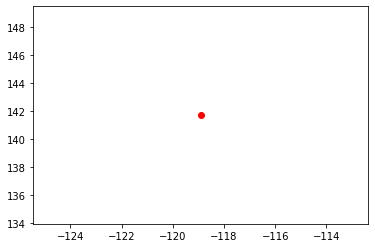

In [33]:
z = 170
sel = lt.z == z

sid = 4

plt.scatter(lt[sel].x, lt[sel].y, c=lt[sel][pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

r = float(config.set_index("parameter").loc["ACTIVE_rad"])
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

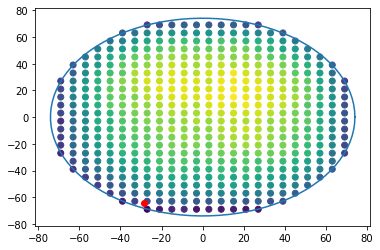

In [ ]:
sid = 3
plt.scatter(lt.x, lt.y, c=lt[pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

r = float(config.set_index("parameter").loc["ACTIVE_rad"])
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [ ]:
df_writer(h5out, conf_psf, "PSF", "Config", str_col_length = conf_psf.value.str.len().max())

In [ ]:
filename = "/mnt/lustre/scratch/home/usc/ie/gdl/NEXT100/LightTables/NEXT100_S2_LT.h5"

lt_ex  = load_dst(filename, "LT", "LightTable")
config = load_dst(filename, "LT", "Config")

In [ ]:
from invisible_cities.core.core_functions import binedges_from_bincenters
xbins = binedges_from_bincenters(np.unique(lt["x"]))
ybins = binedges_from_bincenters(np.unique(lt["y"]))

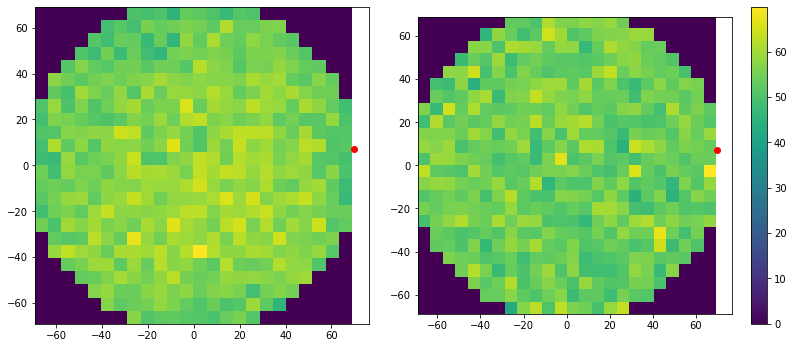

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5])
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
# light table
h, _, _ = np.histogram2d(lt["x"], lt["y"], weights=lt[sensor_id], bins=[xbins, ybins])
im0 = ax0.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
# fig.colorbar(im0, ax=ax0)

# err
h, _, _ = np.histogram2d(err["x"], err["y"], weights=err[sensor_id], bins=[xbins, ybins])
im1 = ax1.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im1, ax=ax1)

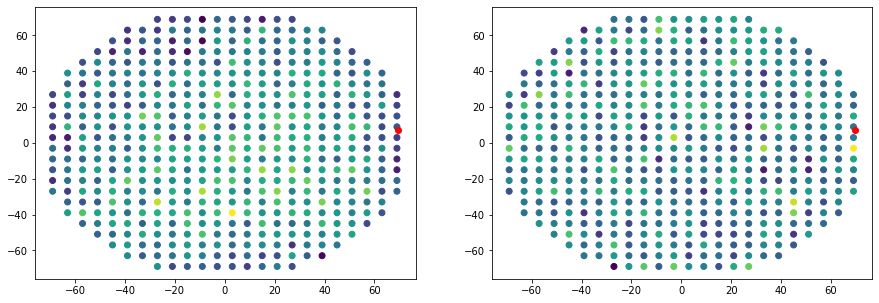

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])
ax1.scatter(err["x"], err["y"], c=err[sensor_id])

ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")

In [ ]:
old_table = os.path.expandvars("$LUSTRE/NEXT100/LightTables/NEXT100_S2_LT.h5")

from invisible_cities.io.dst_io import load_dst
old = load_dst(old_table, "LT", "LightTable")

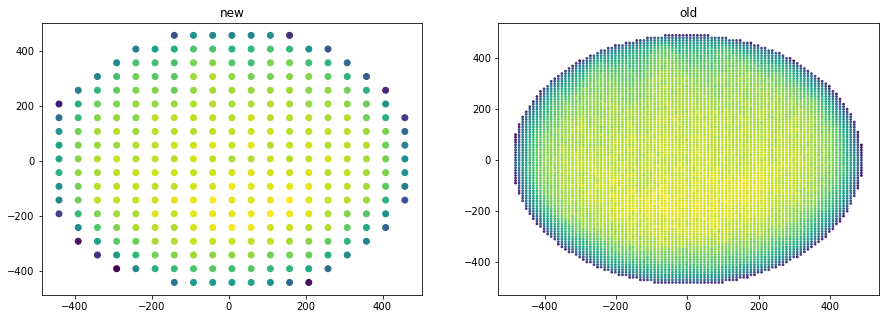

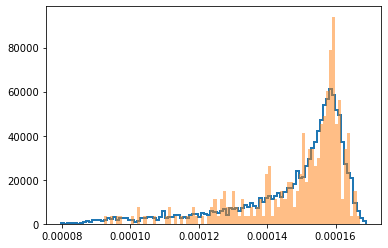

In [ ]:
sensor_id = 31

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])

ax0.set_title("new")
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])


ax1.set_title("old")
ax1.scatter(old["x"], old["y"], c=old[f"PmtR11410_{sensor_id}"], s=3)


plt.figure()
_, bins, _ = plt.hist(old[f"PmtR11410_{sensor_id}"], bins=100 , density=True, histtype="step", linewidth=2)
_, _   , _ = plt.hist(lt[sensor_id]                , bins=bins, density=True, alpha=0.5);